# Random Forest Fraud Check

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
#from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
#import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
fraud = pd.read_csv('Fraud_check.csv')

In [3]:
fraud

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [4]:
fraud.columns = ['Undergrad', 'Marital_Status', 'Taxable_Income_target', 'City_Population', 'Work_Experience', 'Urban']

In [5]:
fraud

,Undergrad,Marital_Status,Taxable_Income_target,City_Population,Work_Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [6]:
fraud['Taxable_Income_target_s'] = fraud['Taxable_Income_target'].apply(lambda x: 1  if  x >= 30000   else 0)
fraud = fraud.drop(['Taxable_Income_target'], axis=1)

In [7]:
fraud['Undergrad'][fraud['Undergrad'] == 0] = 'NO'
fraud['Undergrad'][fraud['Undergrad'] == 1 ]= ' YES'

fraud['Urban'][fraud['Urban'] == 0] = 'NO'
fraud['Urban'][fraud['Urban'] == 1 ]= ' YES'

fraud['Marital_Status'][fraud['Marital_Status'] == 1] = 'Single'
fraud['Marital_Status'][fraud['Marital_Status'] == 2]= ' Divorced'
fraud['Marital_Status'][fraud['Marital_Status'] == 3] = 'Married'


In [8]:
fraud.dtypes

Undergrad                  object
Marital_Status             object
City_Population             int64
Work_Experience             int64
Urban                      object
Taxable_Income_target_s     int64
dtype: object

In [9]:
fraud['Undergrad']= fraud['Undergrad'].astype('object')
fraud['Urban']= fraud['Urban'].astype('object')
fraud['Marital_Status']= fraud['Marital_Status'].astype('object')


In [10]:
fraud.dtypes

Undergrad                  object
Marital_Status             object
City_Population             int64
Work_Experience             int64
Urban                      object
Taxable_Income_target_s     int64
dtype: object

In [11]:
fraud = pd.get_dummies(fraud, drop_first=True)

In [12]:
fraud

,City_Population,Work_Experience,Taxable_Income_target_s,Undergrad_YES,Marital_Status_Married,Marital_Status_Single,Urban_YES
0,50047,10,1,0,0,1,1
1,134075,18,1,1,0,0,1
2,160205,30,1,0,1,0,1
3,193264,15,1,1,0,1,1
4,27533,28,1,0,1,0,0
...,...,...,...,...,...,...,...
595,39492,7,1,1,0,0,1
596,55369,2,1,1,0,0,1
597,154058,0,1,0,0,0,1
598,180083,17,1,1,1,0,0


# The Model

The next part fits a random forest model to the data,

In [14]:
X_train, X_test, y_train, y_test = train_test_split(fraud.drop('Taxable_Income_target_s', 1), 
                                                    fraud['Taxable_Income_target_s'], test_size = .2, random_state=10) 
#split the data

In [15]:
model = DecisionTreeClassifier(criterion="entropy",max_depth=5)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
#estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'Risky'
y_train_str[y_train_str == '1'] = 'Good'
y_train_str = y_train_str.values

In [18]:
export_graphviz(model, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'fraud.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'fraud.png')

This gives us on explainability tool. However, I can't glance at this and get a quick sense of the most important features. We'll revisit those later. Next, let's evaluate the model,

In [19]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [20]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[ 3, 23],
       [11, 83]], dtype=int64)

In [21]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.21428571428571427
Specificity :  0.7830188679245284


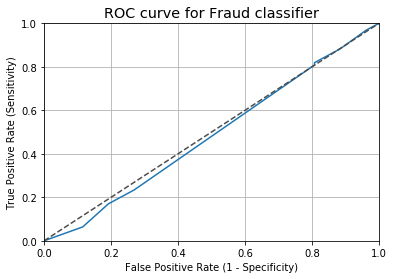

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Fraud classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [23]:
auc(fpr, tpr)

0.4834288052373158

# The Explanation

Now let's see what the model gives us from the ML explainability tools.
Permutation importance * is the first tool for understanding a machine-learning model, and involves shuffling individual variables in the validation data (after a model has been fit), and seeing the effect on accuracy.

In [24]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0117 ± 0.0501,Work_Experience
0 ± 0.0000,Urban_YES
0 ± 0.0000,Marital_Status_Single
0 ± 0.0000,Marital_Status_Married
0 ± 0.0000,Undergrad_YES
-0.0083 ± 0.0365,City_Population


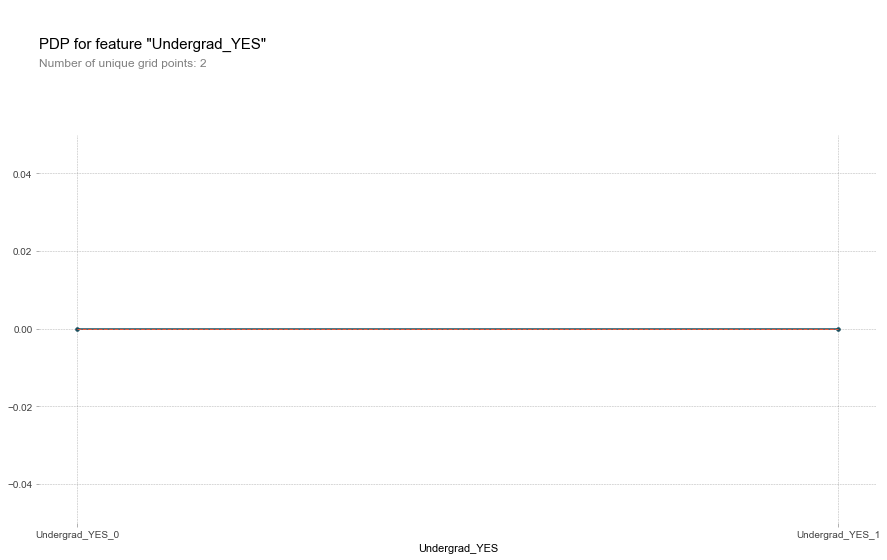

In [25]:
base_features = fraud.columns.values.tolist()
base_features.remove('Taxable_Income_target_s')

feat_name = 'Undergrad_YES'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

So, we can see that as the Undergrad increases, the probability of Risk is  decreases. That makes sense, as it means more income can get to the goodness of financial health.

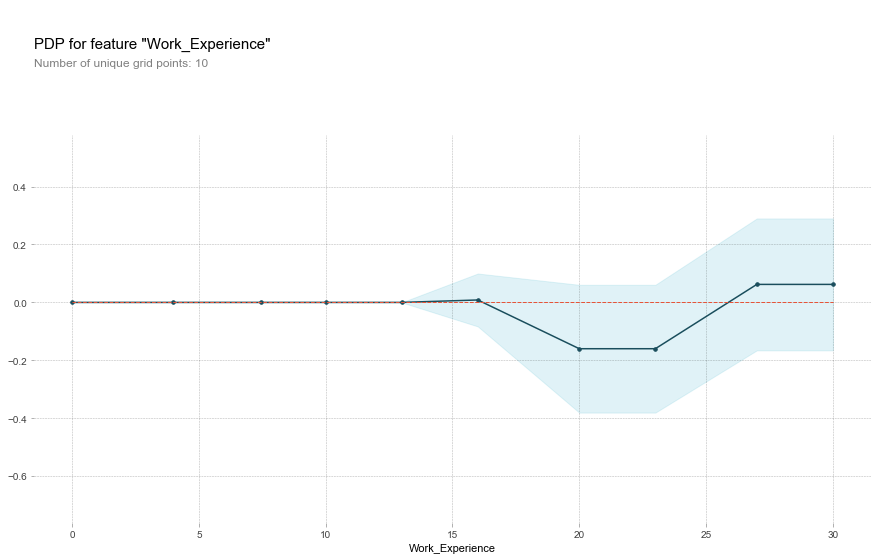

In [26]:
 feat_name = 'Work_Experience'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [27]:
from sklearn.metrics import classification_report, accuracy_score


print(classification_report(y_test, y_pred_bin))
print(" Accuracy of Model is : ",accuracy_score(y_test, y_pred_bin))

              precision    recall  f1-score   support

           0       0.21      0.12      0.15        26
           1       0.78      0.88      0.83        94

    accuracy                           0.72       120
   macro avg       0.50      0.50      0.49       120
weighted avg       0.66      0.72      0.68       120

 Accuracy of Model is :  0.7166666666666667


# Conclusion

It has been observed that , Accuracy of Decision Tree Classifier  model has 78.33 %.